# **Avance 2. Ingeniería de características (Feature Engineering)**

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335

In [4]:
# Importar Librerias.
# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias generales de matematicas
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Librerias Locales del Repositorio.
from watermark.features import Utilities
from watermark.dataset import DataHandler

# Librerias de Machine Learning.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import pad_sequences  # Para ajustar secuencias de entrada a una longitud específica

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Cargamos los datos.
dh = DataHandler() # Objeto manejador de datos.
data_dict = dh.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-02 20:37:59.852 | INFO     | watermark.dataset:load_data:51 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-02 20:38:00.000 | SUCCESS  | watermark.dataset:load_data:56 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


## Manejo de Datos

In [50]:
# Obtener los datos de interes del dataset.
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]] 


In [53]:
# Generamos una copia en forma de lista de los datos en los diccionarios.
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Usuarios:", len(list_data_x))
print("Número de Tareas realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))

Número de Usuarios: 7
Número de Tareas realizadas: 129
Número de Muestras por Tarea: 1474


- A continuación queremos estandarizar la longitud de todas las tareas, por lo que es necesario cortar algunas que no cumplan con nuestro largo máximo (1500) por lo que usaremos la función "get_extended_data" para esta tarea. De igual manera utilizamos una lista de strides para mantener una proporción similar en las muestras que requieran ser recortadas.

In [31]:
strides=[600, 1500, 1300, 100, 50, 1200, 900] # Estos valores se seleccionaron para mantener una proporción similar de muestras de cada una de las tareas
limit_len = 1500  # Longitud límite de las secuencias utilizadas para el entrenamiento de las redes
# Obtenemos las secuencias extendidas de las variables X, Y y Pressure
sequences_list_x = dh.get_extended_data(list_data_x, strides, limit_len)
sequences_list_y = dh.get_extended_data(list_data_y, strides, limit_len)
sequences_list_p = dh.get_extended_data(list_data_p, strides, limit_len)


Text(0.5, 1.0, 'Secuencia de Usuario 1, Tarea 2, X')

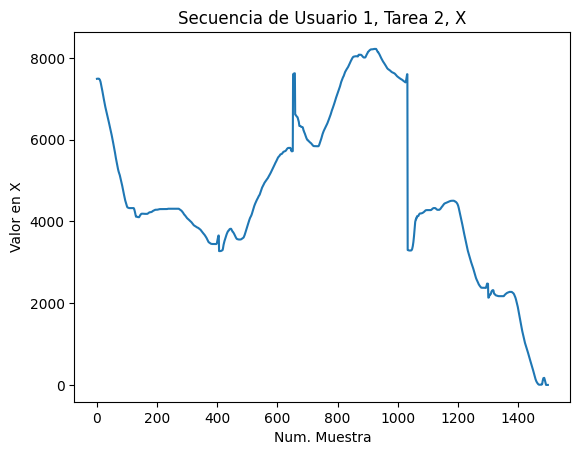

In [54]:
# Graficamos una secuencia de puntos X despues de implementar el proceso de extension.
plt.plot(sequences_list_x[0][1])
plt.xlabel("Num. Muestra")
plt.ylabel("Valor en X")
plt.title("Secuencia de Usuario 1, Tarea 2, X")   

- Aplicamos un padding (Añadir una secuencia de ceros) para estandarizar algunas señales que debido al proceso de extensión anterior no quedaron con la longitud deseada.

In [39]:
# Estandarizamos todas las señales.
x_data =[]
y_data = []
p_data = []

for i, x in enumerate(sequences_list_x): x_data.append(pad_sequences(x, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, y in enumerate(sequences_list_y): y_data.append(pad_sequences(y, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, p in enumerate(sequences_list_p): p_data.append(pad_sequences(p, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))



In [40]:
# Combinar las secuencias de todas las tareas en un solo arreglo
# Apilar secuencias de las tareas verticalmente para cada variable.
x_tasks_data = np.vstack(x_data) 
y_tasks_data = np.vstack(y_data) 
p_tasks_data = np.vstack(p_data) 

print(f'Dimensiones finales para X: {x_tasks_data.shape}')
print(f'Dimensiones finales para Y: {y_tasks_data.shape}')
print(f'Dimensiones finales para Pressure: {p_tasks_data.shape}')

Dimensiones finales para X: (2177, 1500)
Dimensiones finales para Y: (2177, 1500)
Dimensiones finales para Pressure: (2177, 1500)


## Generación de Watermarks

In [55]:
# Generamos un objeto de utilities para las funciones.
util = Utilities()

In [19]:
# Sacamos las caracterisitcas "Wavelet" para cada una de las tareas agrupadas 
signs_x_wavelet = np.array([util.sign2wavelet(firma) for firma in x_tasks_data])
signs_y_wavelet = np.array([util.sign2wavelet(firma) for firma in y_tasks_data])

In [ ]:
# Concatenar características X e Y
firmas_wavelet = np.hstack([signs_x_wavelet, signs_y_wavelet])
num_firmas = firmas_wavelet.shape[0]
print("Forma de las características extraídas:", firmas_wavelet.shape)

Forma de las características extraídas: (2177, 36)


In [ ]:
# Generamos 100 fechas diferentes utilizando una funcion.
dates_list = util.dates_generator(100)
print("Fecha de Prueba: ", dates_list[50])
# Mandamos llamar una funcion para generar un diccionario de hashes para cada fecha
dates_hashes = {date:util.hashear_fecha(date) for date in dates_list} 
fechas_lista = list(dates_hashes.items())

print("Ejemplo de fechas generadas y sus hashes:")
for i in range(3):
    print(f"Fecha: {fechas_lista[i][0]}, Hash: {fechas_lista[i][1][:5]}...")  # Muestra los primeros valores del hash

Fecha de Prueba:  2022/07/26 19:20:14
Ejemplo de fechas generadas y sus hashes:
Fecha: 2008/03/29 01:52:59, Hash: [ 81 143 167 237 214]...
Fecha: 2011/11/08 15:47:40, Hash: [228 156 107 182 118]...
Fecha: 2000/04/30 01:28:47, Hash: [ 45  28 172 223 155]...


In [43]:
# Generamos una lista de aleatoria utilizando las 100 fechas creadas.
fechas_asignadas = random.choices(fechas_lista, k=num_firmas)
hashes_entrenamiento = np.array([hash for _, hash in fechas_asignadas])
print("Forma de los hashes de entrenamiento:", hashes_entrenamiento.shape)  # Debe ser (2177, 32)

Forma de los hashes de entrenamiento: (2177, 32)


##  Prototipo Inicial de Red Neuronal Generadora. (Encoder)

- Inserte explicación sobre los hashes y las caracteristicas de las señales.

In [24]:
input_dim = firmas_wavelet.shape[1]  # Número de características extraídas - 36
hash_dim = hashes_entrenamiento.shape[1]  # 32 valores del hash - 36

# Definir la red neuronal generadora
inputs = keras.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation="relu")(inputs)
encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.Dense(hash_dim, activation="sigmoid")(encoded)  # 32 valores de salida

modelo_generador = keras.Model(inputs, encoded)
modelo_generador.compile(optimizer="adam", loss="mse")

# Entrenamiento con múltiples fechas
modelo_generador.fit(firmas_wavelet, hashes_entrenamiento, epochs=200, batch_size=16, verbose=1)


Epoch 1/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21390.6328 
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21477.5195
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21358.2637
Epoch 4/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21514.4609
Epoch 5/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21394.7246
Epoch 6/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21333.5469
Epoch 7/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21449.9824
Epoch 8/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21315.8203
Epoch 9/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21364.8047
Epoch 10/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21459.5898
Epoch 11/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21361.8535
Epoch 12/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21409.0938
Epoch 13/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21498.8301
Epoch 14/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los